### Multiple Linear Regression Python 101
* [Step-by-step guide for data preparation and predictive modeling](https://towardsdatascience.com/multiple-linear-regression-python-101-af459110a8af)
* [Home-Sales-Predictive-Model](https://github.com/cutterback/p02-home-sales-predictive-project/blob/master/Home-Sales-Predictive-Model.ipynb)

![](https://miro.medium.com/max/2000/1*51xHEHLvhEVcCr8Zt1QBtw.png)

Step 1 — Data Prep Basics

In [1]:
# import all libraries required to load, transform, analyze and plot
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox

import scipy.stats as stats
from haversine import haversine #to calculate mileage

# set display option to remove scientific notation and 
# remove restrictions on dataframe rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [2]:
# load Kings County data set (primary driver dataframe)
kc = pd.read_csv('../data/kc_house_data.csv')
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [3]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
# fill nulls with 0 for waterfront, view and yr_renovated
kc.fillna({'waterfront' : 0, 'view' : 0, 'yr_renovated': 0}, inplace=True)

# data type conversions
kc['date']= pd.to_datetime(kc['date']) # conversion helps use column for month and year
kc['yr_renovated']=kc['yr_renovated'].astype(int) # convert to proper data type

# clean sqft basement, replacing ? values with 0 as no basement
# object requires conversion of decimals to str, then to int to avoid error
kc.sqft_basement.replace('?', 0, inplace=True)
kc['sqft_basement']=kc['sqft_basement'].astype(float).astype(int)

In [5]:
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"4,580,301,520.86","540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,3.41,7.66,"1,788.39",291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,"1,986.55","12,768.46"
std,"2,876,565,571.31","367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,"27,304.18"
min,"1,000,102.00","75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,194.00","321,950.00",3.00,1.75,"1,427.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00",0.00,"1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00","645,000.00",4.00,2.50,"2,550.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,210.00",560.00,"1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","4,820.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


In [6]:
# set up mask for any outlier filters; in the end only bedrooms
mask = kc.loc[kc['bedrooms']>20].index

# drop rows by index for outliers using mask
kc.drop(mask, inplace=True)
kc.shape

(21612, 21)

In [7]:
# function checks column outliers and skew; tests normality showing a histogram
def check_normality(df, col, bins=20):
    """Plots histogram; prints 4th positive standard deviation and observation 
    counts, skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to check; must be in df.columns.
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    std4 = df[col].mean()+4*df[col].std()
    std4_cnt = len(df[df[col]>std4])
    print(f'{col} 4 Std Dev: {std4} | Home Counts above this size: {std4_cnt} | Skew: {df[col].skew()} | Kurtosis: {df[col].kurtosis()}')
    df[col].hist(figsize=(8,4), bins=bins)
    return

In [8]:
# boxcox transformation leaves last row with nan. replacing with median.
def box_fillna(df, column):
    median = df[column].median()
    df[column] = df[column].astype('string')
    df[column].replace(np.nan, median, inplace=True)
    df[column] = df[column].astype('float')

In [9]:
def create_log(df, column, col_pos=0, bins=20):
    """Creates new column using log transformation. Plots histogram for original 
    and new log column; prints skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to create new log column; must be in df.columns.
    col_pos (int): Desired position number for new column; default set to 0
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    col_log_name = f'{column}_log'
    df.insert(loc=col_pos, column=col_log_name, value=np.log(df[column]))
    df[[column, col_log_name]].hist(figsize=(12,4), bins=bins)
    plt.show()
    print(f'{col_log_name} skew: {df[col_log_name].skew()}')
    print(f'{col_log_name} kurtosis: {df[col_log_name].kurtosis()}')
    return

**Price Log**

price 4 Std Dev: 2008623.763860351 | Home Counts above this size: 197 | Skew: 4.024033595653388 | Kurtosis: 34.58426184766218


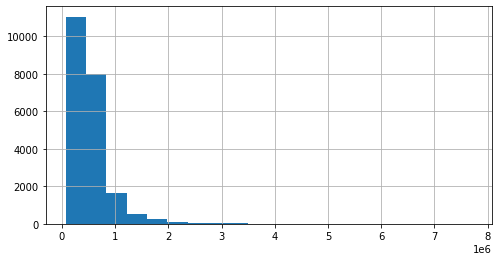

In [10]:
check_normality(kc, 'price', bins=20)
# Skew 4 --> positive skew: The right tail is longer
# Kurtosis --> är ett mått för hur sannolika de mer extrema utfallen 
# * En fördelning med kurtosis större än tre kallas leptokurtosisk  
#   kännetecknas av en hög, smal topp kring medelvärdet samt tjocka svansar ("fat tails")


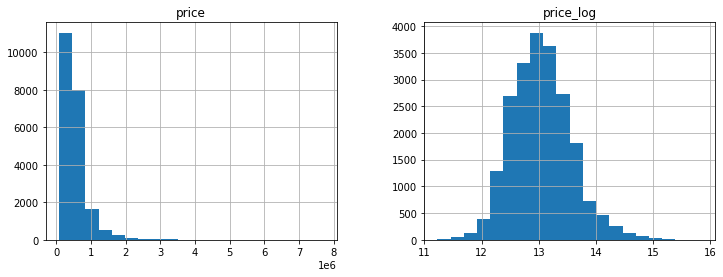

price_log skew: 0.4281478380373607
price_log kurtosis: 0.6918523269241916


In [11]:
# Creating price log column given skew
create_log(kc, 'price', col_pos=3, bins=20)

**Notes of Price Log**

* Price is highly skewed with 198 values more than 4 standard deviations from the mean
* Going ahead and creating price_log column and as shown above, it's relatively normal with little skew.
* Price log looks great, 0.4 skew and 0.7 kurtosis, should hold up much better in linear models.
* Price_log will be available for use in Model section

**Price Box**¶

-0.23406149440983617
price_box 4 Std Dev: 4.167427234191891 | Home Counts above this size: 1 | Skew: -0.012155992505471952 | Kurtosis: 0.3154984774912992


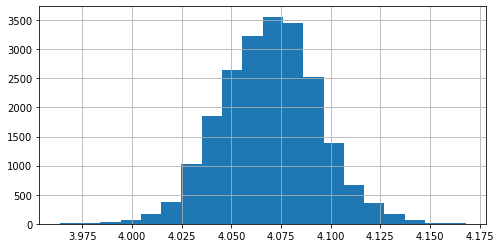

In [12]:
# apply boxcox to price to see if this feature is better than price_log
price_box = []
price_box, price_lambda = stats.boxcox(kc.price)
kc.insert(loc=4, column='price_box', value=pd.Series(price_box))
print(price_lambda)
check_normality(kc, 'price_box', bins=20)

* [Box-Cox Transformation: Explained](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203)
  * [Forecasting: Principles and Practice](https://otexts.com/fpp2/)

Step 2 — Split Data Into Training and Test Sets

In [13]:
# divide dataset into X predictors and y target
X = kc_comb.drop(['price', 'price_log', 'price_box'], axis=1)
y = kc_comb[['price', 'price_log', 'price_box']]

# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

NameError: name 'kc_comb' is not defined